In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in datafile

In [2]:
#pd.set_option('display.max_columns', None)
df = pd.read_csv("rawJailDataIntern.csv")

For ease of interpretation, let's use county name instead of the FIPS code. 

In [3]:
df['county'] = df['facility_name'].str.split(' ').str[0] # use county name instead of FIPS
df = df.drop(columns = ['facility_name'])

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,fips,year,rated_capacity,total_confined_pop,adp,confined_women,confined_men,admissions_year,admissions_week,admissions_day,discharge_year,discharge_week,discharge_day,county
0,6059,1985,1864.0,2844.0,2767.0,364,2476.0,93086.0,NaN,NaN,92834.0,NaN,NaN,ORANGE
1,6059,1986,2496.0,3217.0,2913.0,375,2842.0,93998.0,NaN,NaN,93642.0,NaN,NaN,ORANGE
2,6059,1987,2775.0,3471.0,3250.0,464,3006.0,77747.0,NaN,NaN,76685.0,NaN,NaN,ORANGE
3,6059,1989,3478.0,4527.0,4281.0,585,3942.0,125325.0,NaN,NaN,122631.0,NaN,NaN,ORANGE
4,6059,1990,3478.0,4402.0,4370.0,510,3892.0,92899.0,NaN,NaN,93416.0,NaN,NaN,ORANGE
5,6059,1992,5289.0,4690.0,4688.0,495,4181.0,NaN,NaN,223.0,NaN,NaN,244.0,ORANGE
6,6059,1994,3821.0,4987.0,4836.0,539,4434.0,NaN,NaN,NaN,NaN,NaN,NaN,ORANGE
7,6059,1995,3821.0,5157.0,5074.0,620,4522.0,NaN,NaN,NaN,NaN,NaN,NaN,ORANGE
8,6059,1996,3821.0,5326.0,5143.0,673,5068.0,NaN,NaN,NaN,NaN,NaN,NaN,ORANGE
9,6059,1997,3821.0,5368.0,5246.0,716,4635.0,NaN,NaN,NaN,NaN,NaN,NaN,ORANGE


# Explore Missingness

### Missingness Table:

In [5]:
# Total Missing Data:
df.isna().sum()

fips                    0
year                    0
rated_capacity          7
total_confined_pop      3
adp                    15
confined_women          0
confined_men           12
admissions_year       122
admissions_week        92
admissions_day        159
discharge_year        122
discharge_week         92
discharge_day         160
county                  0
dtype: int64

### 3 Takeaways from the missingness table:

1. **Impute admissions_year based on admissions_day and admissions_week**: Missingness for admissions_year and discharge_year usually happen at the same time, so we can focus on admissions_year to fix missingness.

2. **Impute confined_men using confined_women**: Because this dataset doesn't take into account folks with non-binary gender identities (confined_other doesn't exist in this dataset), it looks like we can fill up some confined_men values by subtracting total_confined_pop by confined_women.

3. **Linear interpolation for admissions_year and discharge_year**: Because admissions_year and discharge_year are the two missing-est columns (besides the day and week columns which we wish to discard later), let's try using linear interpolation to fill the missing values on these two columns..

# 1. Impute admissions_year based on admissions_day and admissions_week

After some exploratory data analysis, it's clear that many of the missing yearly values for admissions and discharge often have either day or week data next to them.

As a **rough estimate**, we can impute the missing year columns by multiplying the weekly and daily data that exists for those years. If anomalous, we will remove them later in the code. 

In [6]:
# impute missing admissions_year data based on admissions_week and admissions_day
df['admissions_year'] = np.where(df.admissions_year.isnull(), df.admissions_week * 52, df.admissions_year)
df['admissions_year'] = np.where(df.admissions_year.isnull(), df.admissions_day * 365, df.admissions_year)

# impute missing discharge_year data based on discharge_week and discharge_day
df['discharge_year'] = np.where(df.discharge_year.isnull(), df.discharge_week * 52, df.discharge_year)
df['discharge_year'] = np.where(df.discharge_year.isnull(), df.discharge_day * 365, df.discharge_year)

Now, let's drop the daily and weekly counts because we wish to remove them in the final output. 

In [7]:
df = df.drop(columns=['admissions_day', 'admissions_week', 'discharge_week', 'discharge_day'])

# 2. Impute confined_men using confined_women

In [37]:
df
df['admissions_year'] = np.where(df.admissions_year.isnull(), df.admissions_week * 52, df.admissions_year)

,fips,year,rated_capacity,total_confined_pop,adp,confined_women,confined_men,admissions_year,discharge_year,county,pct_capacity_change,pct_adp_change,pct_pop_change,pct_admissions_change,pct_discharge_change
0,6059,1985,1864.0,2844.0,2767.0,364,2476.0,93086.0,92834.0,ORANGE,NaN,NaN,NaN,NaN,NaN
1,6059,1986,2496.0,3217.0,2913.0,375,2842.0,93998.0,93642.0,ORANGE,0.339056,0.052765,0.131153,0.009797,0.008704
2,6059,1987,2775.0,3471.0,3250.0,464,3006.0,77747.0,76685.0,ORANGE,0.111779,0.115688,0.078956,-0.172887,-0.181083
3,6059,1989,3478.0,4527.0,4281.0,585,3942.0,125325.0,122631.0,ORANGE,0.253333,0.317231,0.304235,0.611959,0.599152
4,6059,1990,3478.0,4402.0,4370.0,510,3892.0,92899.0,93416.0,ORANGE,0.000000,0.020790,-0.027612,-0.258735,-0.238235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,56043,1978,10.0,1.0,NaN,0,1.0,156.0,156.0,WASHAKIE,-0.230769,0.000000,0.000000,-0.974765,-0.980645
163,56043,1983,10.0,3.0,NaN,1,2.0,413.0,413.0,WASHAKIE,0.000000,0.000000,2.000000,1.647436,1.647436
164,56043,1988,56.0,12.0,9.0,1,10.0,543.0,537.0,WASHAKIE,4.600000,-0.975676,3.000000,0.314770,0.300242
165,56043,1993,42.0,14.0,16.0,1,13.0,NaN,NaN,WASHAKIE,-0.250000,0.777778,0.166667,0.000000,0.000000


# 3. Linear interpolation for admissions_year and discharge_year


### Pivot data for interpolation

Pivot to make admissions and discharge data comparable on the year level. Pivoting to a longer format will also make ease for linear interpolation from year to year later.

In [109]:
df_pivoted = df.pivot(columns = 'county', index = 'year', values = ['admissions_year', 'discharge_year'])
df_pivoted

admissions_year                                                       \
county           ADAMS BALLARD  BARREN  BRISTOL  COLLIER   MARION    ORANGE   
year                                                                          
1970               NaN     NaN     NaN      NaN      NaN      NaN       NaN   
1978             156.0     NaN     NaN      NaN      NaN      NaN       NaN   
1983             138.0  1230.0     NaN      NaN      NaN      NaN       NaN   
1985               NaN     NaN     NaN   1605.0  10595.0  12000.0   93086.0   
1986               NaN     NaN     NaN   1804.0  11483.0  13200.0   93998.0   
1987               NaN     NaN     NaN   1975.0   8098.0  11158.0   77747.0   
1988             119.0   345.0     NaN      NaN      NaN      NaN       NaN   
1989               NaN     NaN     NaN   2085.0  11121.0  11549.0  125325.0   
1990               NaN     NaN     NaN   2439.0  11212.0  11600.0   92899.0   
1991             272.0     NaN     NaN      NaN      NaN      NaN       NaN   
1992               NaN     NaN     NaN   1825.0   8395.0  41975.0   81395.0   
1993          364635.0   365.0     NaN      NaN      NaN      NaN       NaN   
1994               NaN     NaN     NaN      NaN      NaN      NaN       NaN   
1995               NaN     NaN     NaN      NaN      NaN      NaN       NaN   
1996               NaN     NaN     NaN      NaN      NaN      NaN       NaN   
1997               NaN     NaN     NaN      NaN      NaN      NaN       NaN   
1998               NaN     NaN  3692.0   5304.0  11024.0  13000.0   65468.0   
1999             468.0   728.0     NaN   1872.0  11752.0      NaN   57564.0   
2000               NaN     NaN  4368.0   7592.0  15756.0      NaN   62608.0   
2001               NaN     NaN   832.0   6240.0  12428.0   2340.0   57356.0   
2002               NaN     NaN     NaN   7280.0  15132.0  61100.0   65312.0   
2003               NaN     NaN  2600.0   8320.0  19188.0  74100.0   64532.0   
2004               NaN     NaN  3016.0  29900.0   2548.0  90896.0   77844.0   
2005             416.0   208.0     NaN   9308.0  22464.0      NaN   67392.0   
2006               NaN     NaN  3640.0      NaN      NaN  60060.0       NaN   
2007               NaN     NaN     NaN  18304.0  83460.0      NaN   59904.0   
2008               NaN     NaN     NaN   9984.0  17316.0      NaN   69784.0   
2009               NaN     NaN     NaN      NaN  14768.0      NaN   62504.0   
2010               NaN     NaN     NaN  13676.0  14716.0      NaN   60580.0   
2011               NaN     NaN     NaN  12792.0  10244.0      NaN   68328.0   
2012               NaN     NaN     NaN   7592.0   9152.0      NaN   68848.0   
2013               NaN     NaN     NaN  12948.0      NaN      NaN   65988.0   
2014               NaN     NaN     NaN   4576.0  10504.0      NaN   60632.0   
2015               NaN     NaN     NaN   6368.0  11263.0      NaN   54727.0   
2016               NaN     NaN     NaN      NaN   9358.0      NaN   56293.0   
2017               NaN     NaN     NaN      NaN   8584.0      NaN   56265.0   
2018               NaN     NaN     NaN      NaN   8496.0      NaN   60918.0   

                                discharge_year                           \
county  PUTNAM WASHAKIE    YORK          ADAMS BALLARD  BARREN  BRISTOL   
year                                                                      
1970       NaN      NaN     NaN            NaN     NaN     NaN      NaN   
1978    4420.0    156.0     NaN          156.0     NaN     NaN      NaN   
1983    2892.0    413.0   208.0          138.0  1230.0     NaN      NaN   
1985       NaN      NaN     NaN            NaN     NaN     NaN   1585.0   
1986       NaN      NaN     NaN            NaN     NaN     NaN   1746.0   
1987       NaN      NaN     NaN            NaN     NaN     NaN   2055.0   
1988    3000.0    543.0   735.0          119.0   338.0     NaN      NaN   
1989       NaN      NaN     NaN            NaN     NaN     NaN   1797.0   
1990       NaN      N

## Identify and Remove Anomalies for admissions_year and discharge_year: 

In this case, we'll define anomalies as a 30% change in admissions or discharge per year from one year to the next recorded year. 

Let's create percent change columns for two datasets:

- `df_pivoted_a` - pivoted dataset that includes percentage change of admissions/year from year to year
- `df_pivoted_d` - pivoted dataset that includes percentage change of discharge/year from year to year

In [93]:
def get_pct_change(df_pivoted, column):
    '''
    Returns longer version of data set to allow for percentage change analysis (to find anomalies)
    
    Specify column (i.e. admissions_year, discharge_year) to choose value to pivot and get percentages of
    '''
    # join the percentages data set with the original df dataset, which includes the percent changes:
    df_pivoted = (df_pivoted[column].join(df_pivoted[column]
                                    .pct_change(fill_method='ffill'), rsuffix='_pct'))
    
    return df_pivoted

df_pivoted_a = get_pct_change(df_pivoted, 'admissions_year')
df_pivoted_d = get_pct_change(df_pivoted, 'discharge_year')

df_pivoted_a

county,ADAMS,BALLARD,BARREN,BRISTOL,COLLIER,MARION,ORANGE,PUTNAM,WASHAKIE,YORK,ADAMS_pct,BALLARD_pct,BARREN_pct,BRISTOL_pct,COLLIER_pct,MARION_pct,ORANGE_pct,PUTNAM_pct,WASHAKIE_pct,YORK_pct
year,,,,,,,,,,,,,,,,,,,,
1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,156.0,NaN,NaN,NaN,NaN,NaN,NaN,4420.0,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,138.0,1230.0,NaN,NaN,NaN,NaN,NaN,2892.0,413.0,208.0,-0.115385,NaN,NaN,NaN,NaN,NaN,NaN,-0.345701,1.647436,NaN
1985,NaN,NaN,NaN,1605.0,10595.0,12000.0,93086.0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1986,NaN,NaN,NaN,1804.0,11483.0,13200.0,93998.0,NaN,NaN,NaN,0.000000,0.000000,NaN,0.123988,0.083813,0.100000,0.009797,0.000000,0.000000,0.000000
1987,NaN,NaN,NaN,1975.0,8098.0,11158.0,77747.0,NaN,NaN,NaN,0.000000,0.000000,NaN,0.094789,-0.294784,-0.154697,-0.172887,0.000000,0.000000,0.000000
1988,119.0,345.0,NaN,NaN,NaN,NaN,NaN,3000.0,543.0,735.0,-0.137681,-0.719512,NaN,0.000000,0.000000,0.000000,0.000000,0.037344,0.314770,2.533654
1989,NaN,NaN,NaN,2085.0,11121.0,11549.0,125325.0,NaN,NaN,NaN,0.000000,0.000000,NaN,0.055696,0.373302,0.035042,0.611959,0.000000,0.000000,0.000000
1990,NaN,NaN,NaN,2439.0,11212.0,11600.0,92899.0,NaN,NaN,NaN,0.000000,0.000000,NaN,0.169784,0.008183,0.004416,-0.258735,0.000000,0.000000,0.000000


Let's identify those anomalies by creating a `get_anomaly_years()` function. This will return the years in which a jail facility has an anomaly. It will remove the anomaly if the percent column has over +/-30% threshold.

We will use this as a helper function for `drop_anomalies()` later. 

In [94]:
def get_anomaly_years(df):
    '''
    returns years that have anomalies and removes anomalies if percent column has over the +/-30% threshold.
    
    Returns a pandas dataframe with the anomalies removed.
    '''
    counties=['ADAMS', 'BALLARD', 'BARREN', 'BRISTOL', 'COLLIER', 'MARION', 'ORANGE', 'PUTNAM', 'WASHAKIE', 'YORK']
    
    anomaly_year = {}
    
    for county in counties: 
        anomaly_year[county] = list(df.loc[(df[county + '_pct'] > .40) | (df[county + '_pct'] < -.40)].index.values)
        
    return anomaly_year

Here are the anomaly years for admissions. Run the second line of code to get the anomaly years for discharge.

In [95]:
get_anomaly_years(df_pivoted_a)
#get_anomaly_years(df_pivoted_d)

{'ADAMS': [1991, 1993, 1999],
 'BALLARD': [1988, 1999, 2005],
 'BARREN': [2001, 2003],
 'BRISTOL': [1998, 1999, 2000, 2004, 2005, 2007, 2008, 2012, 2013, 2014],
 'COLLIER': [2004, 2005, 2007, 2008],
 'MARION': [1992, 1998, 2001, 2002],
 'ORANGE': [1989],
 'PUTNAM': [1993, 2005, 2017],
 'WASHAKIE': [1983, 1999],
 'YORK': [1988, 2005]}

#### Research Bristol County House of Correction and Jail:

Based on this, we can see that Bristol has many anomalous years for its admissions per year. For instance, Bristol's admissions per year ranges from 1605.0 people/year to 29900.0 people/year. 

Doing some online research, Bristol County House of Correction and Jail has a capacity of 1100 bed facility houses. [<sup>1</sup>](#fn1) Thus, it seems improbable that Bristol County would have a yearly entry of 29900.0 people/year, because each bed would hold 27 people per year if true. Thus, when cleaning the data later using the function, I will pay close attention to making sure that the data that is removed are the numbers closer to 29900.0. 

<span id="fn1"><sup>1</sup>Bristol County Facilities: https://www.bcso-ma.us/facilities.htm</span>

In [106]:
def drop_anomalies(df):
    '''
    Drop anomaly years. Uses get_anomaly_years(df) helper function to identify the anomalies
    '''
    counties=['ADAMS', 'BALLARD', 'BARREN', 'BRISTOL', 'COLLIER', 'MARION', 'ORANGE', 'PUTNAM', 'WASHAKIE', 'YORK']
    anomaly_years_dict = get_anomaly_years(df) # use get_anomaly_years(df) function to find anomaly years
    for county in counties:
        for year in anomaly_years_dict[county]:
            df.loc[year, county] = np.NaN
    df = df.drop(columns = [county + '_pct' for county in counties]) # drop the percentage columns because we don't need them anymore
    return df

In [133]:
df_remove_anomalies_a = drop_anomalies(df_pivoted_a)
df_remove_anomalies_d = drop_anomalies(df_pivoted_d)
df_remove_anomalies_d



county,ADAMS,BALLARD,BARREN,BRISTOL,COLLIER,MARION,ORANGE,PUTNAM,WASHAKIE,YORK
year,,,,,,,,,,
1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,156.0,NaN,NaN,NaN,NaN,NaN,NaN,4056.0,156.0,NaN
1983,138.0,1230.0,NaN,NaN,NaN,NaN,NaN,2892.0,NaN,208.0
1985,NaN,NaN,NaN,1585.0,10558.0,11859.0,92834.0,NaN,NaN,NaN
1986,NaN,NaN,NaN,1746.0,11332.0,12936.0,93642.0,NaN,NaN,NaN
1987,NaN,NaN,NaN,2055.0,7074.0,11154.0,76685.0,NaN,NaN,NaN
1988,119.0,NaN,NaN,NaN,NaN,NaN,NaN,2924.0,537.0,NaN
1989,NaN,NaN,NaN,1797.0,NaN,10499.0,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,2200.0,10755.0,10550.0,93416.0,NaN,NaN,NaN


Convert back to long:

In [136]:
df_a = df_remove_anomalies_a.melt(value_name = "admissions_year", id_vars = "year")
df_d = df_remove_anomalies_d.melt(value_name = "admissions_year")

KeyError: 'year'

In [135]:
df_d

,county,admissions_year
0,ADAMS,NaN
1,ADAMS,156.0
2,ADAMS,138.0
3,ADAMS,NaN
4,ADAMS,NaN
...,...,...
365,YORK,NaN
366,YORK,NaN
367,YORK,NaN
368,YORK,NaN


In [129]:
df_remove_anomalies_a.join(df_remove_anomalies_d, on = 'county')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

# Interpolation:

Add years that the dataframe doesn't currently capture (i.e. 1984). Using equal intervals is important for linear interpolation, because unequal intervals skews the interpolated values.

In [18]:
data = {'year':list(range(1983, 2019))}

year_df = pd.DataFrame(data) 

# add new years
df_pivoted = (df_pivoted.merge(year_df, how = 'right', on = 'year')
             .set_index('year'))

In [19]:
df_pivoted.count()

ADAMS        3
BALLARD      1
BARREN       3
BRISTOL     36
COLLIER     36
MARION       7
ORANGE      36
PUTNAM      36
WASHAKIE     1
YORK         2
dtype: int64

Based on this table, for the years between 1983 and 2018, the only county jails that have a substantial amount of data for yearly jail releases are Bristol, Collier, Orange, Marion, and Putnam. 

Because there are a substantial amount of counties that have fewer than 5 observations over a 35 year period, I don't want to extrapolate. Thus, I'll limit the linear interpolation to 3. This means that when .interpolate() is applied, it will only fill a maximum of 3 consecutive NaNs at a time.

In [28]:
df_interpolated = df_pivoted.interpolate(limit_direction = 'both', limit = 3)
df_interpolated

,ADAMS,BALLARD,BARREN,BRISTOL,COLLIER,MARION,ORANGE,PUTNAM,WASHAKIE,YORK
year,,,,,,,,,,
1983,138.000000,NaN,NaN,1804.000000,11483.000000,13200.000000,93086.000000,2892.0,NaN,NaN
1984,134.200000,NaN,NaN,1804.000000,11483.000000,13200.000000,93086.000000,2913.6,NaN,NaN
1985,130.400000,NaN,NaN,1804.000000,11483.000000,13200.000000,93086.000000,2935.2,543.0,NaN
1986,126.600000,NaN,NaN,1804.000000,11483.000000,13200.000000,93998.000000,2956.8,543.0,NaN
1987,122.800000,NaN,NaN,1975.000000,8098.000000,11158.000000,77747.000000,2978.4,543.0,NaN
1988,119.000000,NaN,NaN,2030.000000,9609.500000,11353.500000,82797.666667,3000.0,543.0,903.0
1989,136.470588,NaN,NaN,2085.000000,11121.000000,11549.000000,87848.333333,3176.0,543.0,903.0
1990,153.941176,365.0,NaN,2439.000000,11212.000000,11600.000000,92899.000000,3352.0,543.0,903.0
1991,171.411765,365.0,NaN,2132.000000,9803.500000,16407.692308,87147.000000,3528.0,543.0,903.0


In [ ]:
Let's plot the data for the post-interpolated dataset:

array([[<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>]], dtype=object)

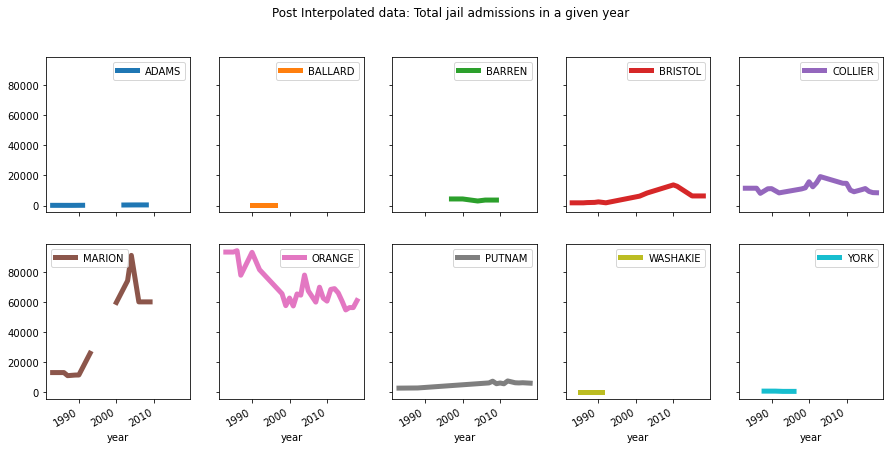

In [30]:
df_interpolated.plot(subplots = True, 
                layout = (2, 5),
               sharey = True,
               title = "Post Interpolated data: Total jail admissions in a given year",
               linewidth = 5,
                figsize=(15,7))

# Write data to new file 

In [ ]:
df.to_csv('cleaned.csv')